# Time series example using RNN

Same as the 01 except optimize batch creation


In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10) 


path='/tmp/'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11736761467988423356
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 5985163674
locality {
  bus_id: 1
}
incarnation: 3844129593034090616
physical_device_desc: "device: 0, name: GeForce GTX TITAN Black, pci bus id: 0000:09:00.0"
]


In [3]:
# Generate seasonal data dataframe
n_cases = 365*10

data=[]
for i in range(n_cases):
    t = (i/100.)
    s = abs((i%7)-3.5)*2.
    data += list(t + s + np.random.randn(1))

index = pd.date_range('1/1/2000', periods=n_cases)
serie = pd.Series(data=data, index=index, name='value')
serie.head


<bound method NDFrame.head of 2000-01-01     6.584524
2000-01-02     4.331548
2000-01-03     3.002717
2000-01-04     2.558897
2000-01-05     2.037236
2000-01-06     3.905935
2000-01-07     2.742447
2000-01-08     7.194843
2000-01-09     5.495719
2000-01-10     3.231856
2000-01-11    -0.317067
2000-01-12     1.619600
2000-01-13     4.258098
2000-01-14     5.174939
2000-01-15     5.035864
2000-01-16     4.487833
2000-01-17     5.587742
2000-01-18     1.927980
2000-01-19     3.784875
2000-01-20     2.336074
2000-01-21     5.892602
2000-01-22     8.635259
2000-01-23     5.305832
2000-01-24     2.648832
2000-01-25     1.046166
2000-01-26     2.529639
2000-01-27     2.939154
2000-01-28     4.353078
2000-01-29     9.201647
2000-01-30     4.799386
                ...    
2009-11-29    40.189652
2009-11-30    38.484641
2009-12-01    37.195168
2009-12-02    37.782711
2009-12-03    38.805691
2009-12-04    42.447423
2009-12-05    44.359235
2009-12-06    40.380283
2009-12-07    40.262743
2009-12-08

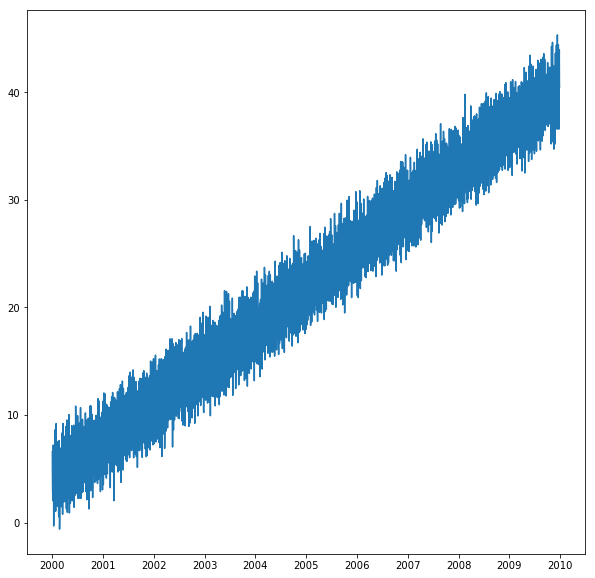

In [4]:
plt.plot(serie)

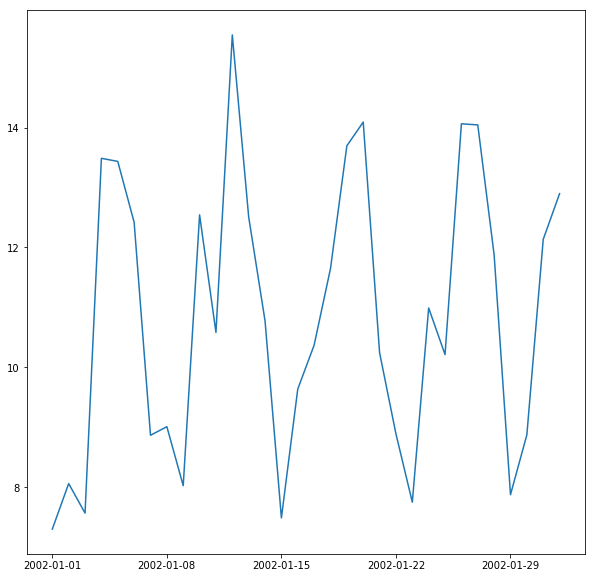

In [5]:
plt.plot(serie['1/1/2002':'2/1/2002'])

In [6]:
# Separate train test and normalize
test_cases = 300
lenght_sequence = 140

data_trn = serie.values[:-test_cases]
data_tst = serie.values[-test_cases-lenght_sequence:]
print(data_trn.shape, data_tst.shape)

# Normalize
range_trn = np.max(data_trn) - np.min(data_trn)
print('Range: ', range_trn)
data_trn = (data_trn/range_trn) -0.5
data_tst = (data_tst/range_trn) -0.5


(3350,) (440,)
Range:  41.7615900872


In [7]:
# Batch generator with sequences extractor
def generate_batch(serie, batch_size=4, x_size=35, y_size=14, shuffle_data=True):
    ''' 
    Generate batches for one epoch
    Randomize order for each epoch
    '''
    serie = np.array(serie) # Convert to array
    
    if len(serie.shape)==1: # if scalar serie convert to vector serie
        serie = np.reshape(serie, [serie.shape[0], 1])
    x_ini_max = serie.shape[0]-x_size-y_size #Max initial position
    
    shuffle_index = [i for i in range(x_ini_max)]
    if shuffle_data:
        from random import shuffle
        shuffle(shuffle_index)
    
    for x_ini in range(0, x_ini_max-batch_size, batch_size): 
        X_batch = np.empty([batch_size, x_size, serie.shape[1]])
        y_batch = np.empty([batch_size, y_size, serie.shape[1]])
        for i in range(batch_size):
            X_batch[i] = serie[shuffle_index[x_ini+i] : shuffle_index[x_ini+i]+x_size, :]
            y_batch[i] = serie[shuffle_index[x_ini+i]+x_size : shuffle_index[x_ini+i]+x_size+y_size, :]
            
        yield np.array(X_batch), np.array(y_batch)
        
gb = generate_batch(data_trn, batch_size=32)
X_b, y_b = next(gb)
print(X_b.shape)
print(y_b.shape)

(32, 35, 1)
(32, 14, 1)


In [8]:
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))

In [9]:
def dense(x, input_size=10, otput_size=1):
    W = tf.Variable(tf.truncated_normal([input_size, otput_size], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[otput_size]))
    return tf.matmul(x,W) + b

In [10]:
# Parameters
lstm_feat = 256
maxlen_y = 14

#Inputs
x_input = tf.placeholder(tf.float32, shape=[None, lenght_sequence, 1], name='x')
y_input = tf.placeholder(tf.float32, shape=[None, maxlen_y], name='y')

keep_prob = tf.placeholder(tf.float32, name='keep_prob')
lstm1 = tf.contrib.rnn.LSTMCell(lstm_feat, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=123))
lstm1 = tf.contrib.rnn.DropoutWrapper(lstm1, output_keep_prob=keep_prob)
lstm_out, _ = tf.nn.dynamic_rnn(lstm1, x_input, dtype=tf.float32, scope='lstm01')

#Final dense layer
y_pred = dense(lstm_out[:,-1,:], input_size=lstm_feat, otput_size=maxlen_y)
print(y_pred)

# Loss function
cost  = tf.reduce_sum(tf.square(y_pred - y_input))

# Trainer
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
train_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

Tensor("add:0", shape=(?, 14), dtype=float32)


In [11]:
# Create test data
gb = generate_batch(data_tst, x_size=lenght_sequence, batch_size=256)
X_tst, y_tst = next(gb)
print(X_tst.shape, y_tst.shape)

(256, 140, 1) (256, 14, 1)


In [12]:
sess.run(tf.global_variables_initializer())

In [13]:
# Train graph
num_epoch=400
batchSize=256

i=0
lr=0.001
for epoch in range(num_epoch):
    c_trn = []
    gb = generate_batch(data_trn, x_size=lenght_sequence, batch_size=batchSize)
    for x_b, y_b in gb:
        feed_dict={x_input: x_b, y_input: np.reshape(y_b, [batchSize,maxlen_y]), learning_rate: lr, keep_prob: 0.9}
        _, c = sess.run([train_step, cost], feed_dict=feed_dict)
        c_trn += [c]
    i += 1
    if i%10==0:
        c_tst = cost.eval(feed_dict={x_input: X_tst, y_input:  np.reshape(y_tst, [256, maxlen_y]), keep_prob: 1})   
        print('Epoch: ', epoch, ' - LR: ',lr, ' - Cost: ',np.mean(c_trn, axis=0), ' - Cost test: ',c_tst )
    #lr *= 0.99

Epoch:  9  - LR:  0.001  - Cost:  15.502  - Cost test:  13.8526
Epoch:  19  - LR:  0.001  - Cost:  5.56599  - Cost test:  5.48265
Epoch:  29  - LR:  0.001  - Cost:  5.00752  - Cost test:  4.12306
Epoch:  39  - LR:  0.001  - Cost:  4.44645  - Cost test:  3.90798
Epoch:  49  - LR:  0.001  - Cost:  3.85469  - Cost test:  7.06455
Epoch:  59  - LR:  0.001  - Cost:  3.81712  - Cost test:  2.9121
Epoch:  69  - LR:  0.001  - Cost:  3.77133  - Cost test:  3.81433
Epoch:  79  - LR:  0.001  - Cost:  3.81951  - Cost test:  6.77781
Epoch:  89  - LR:  0.001  - Cost:  3.57096  - Cost test:  3.32347
Epoch:  99  - LR:  0.001  - Cost:  4.05132  - Cost test:  2.82636
Epoch:  109  - LR:  0.001  - Cost:  3.08125  - Cost test:  3.0916
Epoch:  119  - LR:  0.001  - Cost:  3.4648  - Cost test:  4.38049
Epoch:  129  - LR:  0.001  - Cost:  2.98971  - Cost test:  2.95172
Epoch:  139  - LR:  0.001  - Cost:  3.20467  - Cost test:  11.1055
Epoch:  149  - LR:  0.001  - Cost:  3.20244  - Cost test:  4.36215
Epoch:  15

[[ 0.37080342  0.41576904  0.47219357  0.4882347   0.44656608  0.3865363
   0.3564775   0.36920783  0.41434169  0.47429657  0.48834443  0.44335648
   0.38644654  0.35942227]]
[[ 0.30778408]
 [ 0.39959501]
 [ 0.40784384]
 [ 0.48743839]
 [ 0.4428385 ]
 [ 0.36116718]
 [ 0.34806546]
 [ 0.35809509]
 [ 0.4348578 ]
 [ 0.4872918 ]
 [ 0.51554264]
 [ 0.46519347]
 [ 0.4192296 ]
 [ 0.32875874]]


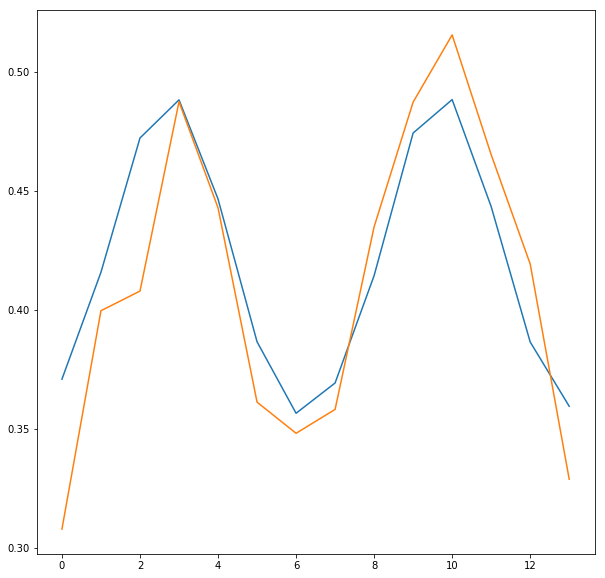

In [14]:
#Score next 14 days
i=3
p_tst = y_pred.eval(feed_dict={x_input: [X_tst[i]], keep_prob: 1})
print(p_tst)
print(y_tst[i])
# Plot for 1 step forecast
plt.plot(p_tst[0])
plt.plot(y_tst[i])
plt.show()  


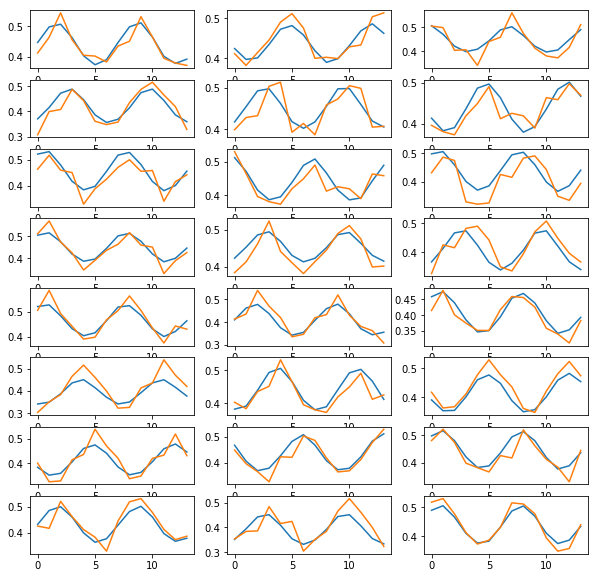

In [15]:
fig = plt.figure()
for i in range(24):
    fig.add_subplot(8,3,i+1)
    p_tst = y_pred.eval(feed_dict={x_input: [X_tst[i]], keep_prob: 1})
    real_vs_pred = np.array([ p_tst[0], y_tst[i][:,0]]).T
    plt.plot(real_vs_pred)